<a href="https://colab.research.google.com/github/camillamelo/analise_vacinas/blob/main/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emoji

     |████████████████████████████████| 133kB 7.7MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Nova seção

In [ ]:
import pandas
import nltk
from nltk.stem import RSLPStemmer
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import emoji
from datetime import datetime

# Busca e tratamento dos textos

In [ ]:
nltk.download('rslp')
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
datapath = '/content/drive/MyDrive/Processed/tweets_vacina_classificadas.csv'

In [ ]:
data = pandas.read_csv(datapath, sep=';', index_col=0)
print('data shape:', data.shape)
print('data columns:', data.columns.tolist())
data.head()

data shape: (2997, 18)
data columns: ['conversation_id', 'date', 'time', 'timezone', 'user_id', 'tweet', 'Antivax', 'language', 'mentions', 'urls', 'replies_count', 'retweets_count', 'likes_count', 'hashtags', 'cashtags', 'link', 'quote_url', 'thumbnail']


,conversation_id,date,time,timezone,user_id,tweet,Antivax,language,mentions,urls,replies_count,retweets_count,likes_count,hashtags,cashtags,link,quote_url,thumbnail
id,,,,,,,,,,,,,,,,,,
1361465304749070000,1361365701844490000,15/02/2021,20:59:58,-300,1323426198433780000,@veramagalhaes O curioso é que o presidente nã...,1,pt,[],[],0,0,0,[],[],https://twitter.com/IramManaus/status/13614653...,NaN,NaN
1361465303146860000,1361465303146860000,15/02/2021,20:59:57,-300,1232025209747770000,Vejam a entrevista do diretor presidente da An...,2,pt,[],['https://youtu.be/0xVeIOjSJ5k'],0,0,0,[],[],https://twitter.com/IvanVeloso3/status/1361465...,NaN,NaN
1361465302345740000,1361462175949340000,15/02/2021,20:59:57,-300,1208738346303970000,"@UOL Já a que não tem vacina, vai gastar tudo ...",0,pt,[],[],0,0,4,[],[],https://twitter.com/Lupacapitolina2/status/136...,NaN,NaN
1361465298302490000,1361265434977330000,15/02/2021,20:59:56,-300,1261792440866000000,"@Josecar43623014 @P6uloP7eto Outra coisa, avis...",2,pt,[],[],2,0,2,[],[],https://twitter.com/AntonyJojohn/status/136146...,NaN,NaN
1361465289368620000,1361465289368620000,15/02/2021,20:59:54,-300,955872635866567000,"SE FOSSE ARMAS, BOLSONARO TERIA COMPRADO DE TO...",0,pt,[],['https://g1.globo.com/bemestar/vacina/noticia...,0,1,3,[],[],https://twitter.com/MARCOSN63533241/status/136...,NaN,NaN


## Proporção de dados
0 -> a favor da vacina

1 -> neutro / indeciso

2 -> antivacina

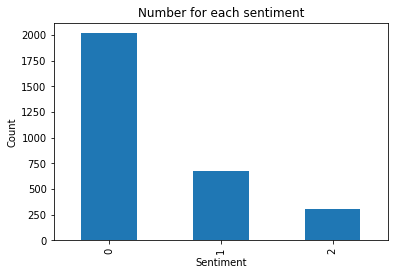

In [ ]:
series = data['Antivax'].value_counts()
ax = series.plot(kind='bar', title='Number for each sentiment')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
plt.show()

In [ ]:
series

0    2017
1     675
2     305
Name: Antivax, dtype: int64

In [ ]:
import unicodedata
def normalize(data):
  """ Normalise (normalize) unicode data in Python to remove umlauts, accents etc. """
  return unicodedata.normalize('NFKD', data).encode('ASCII', 'ignore')

In [ ]:
tweets_text = data.tweet.values.tolist()


In [ ]:
stemmer_ptbr = RSLPStemmer()
def stemming_tokenizer(str_input):
    raw_text = emoji.demojize(str_input, language='pt', delimiters=(' ', ' '))
    raw_text = raw_text.lower()
    raw_text = re.sub(r'@[\w]*', "mencao", raw_text) 
#    raw_text = re.sub(r'@[\d]*', "numero", raw_text)
    raw_text = re.sub(r'haha*', "risada ", raw_text) 
    raw_text = re.sub(r'hehe*', "risada ", raw_text) 
    raw_text = re.sub(r'hihi*', "risada ", raw_text) 
    raw_text = re.sub(r'kk*', "risada ", raw_text) 
    raw_text = re.sub(r'https://[\w]*', "link", raw_text.replace('.', ''))
    raw_text = re.sub(r'http://[\w]*', "link", raw_text)
    raw_text = raw_text.replace('#', '')
    raw_text = normalize(raw_text).decode('utf-8')
    raw_text = raw_text.replace('!', '').replace('?', '').replace(',', '').replace(')', '').replace('(', '').replace('"', '').replace('“', '').replace('‘', '').replace('~', '').replace(':', '')
    raw_text = raw_text.replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace('|', '').replace('-', '').replace("'", '').replace('#', '')
    words = raw_text.split()
    response = []
    for word in words:
        if word not in stopwords:
            response.append(word)
    return response

Demonstração do tokenizer

In [ ]:
stemming_tokenizer('naïve café @lalala @_lalal @TR_amama @haha @HahHaa oi... http://www.a.com kkkkkkk 🤨123')

['naive',
 'cafe',
 'mencao',
 'mencao',
 'mencao',
 'mencao',
 'mencao',
 'oi',
 'link',
 'risada',
 'rosto_com_sobrancelha_levantada',
 '123']

In [ ]:
vectorizer_tfidf = TfidfVectorizer(stop_words=stopwords, tokenizer=stemming_tokenizer, max_df=0.99, min_df=0.001, max_features=1500)
X = vectorizer_tfidf.fit_transform(tweets_text)
vocab = np.array(vectorizer_tfidf.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ate', 'eramos', 'estao', 'estavamos', 'estiveramos', 'estivessemos', 'foramos', 'fossemos', 'ha', 'hao', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'ja', 'nao', 'sao', 'sera', 'serao', 'seriamos', 'so', 'tambem', 'tera', 'terao', 'teriamos', 'tinhamos', 'tiveramos', 'tivessemos', 'voce', 'voces'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Foi limitado em 1500 features para evitar problemas na utilização do modelo gerado

In [ ]:
X.shape

(2997, 1500)

Text(0.5, 0, '# Ocorrência das palavras')

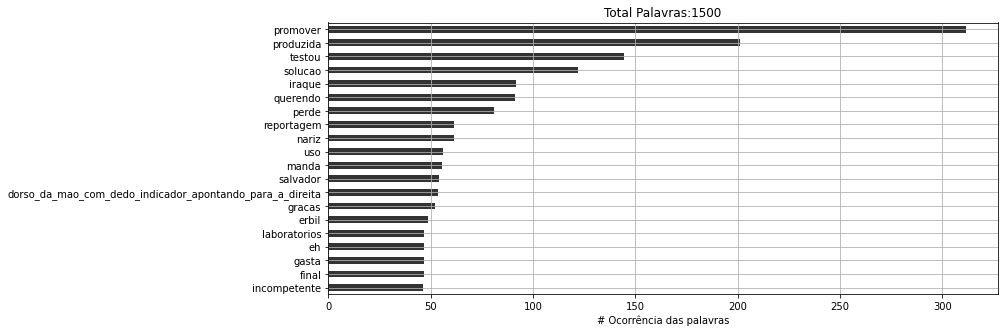

In [ ]:
plt.figure(figsize=(12,5))
nshow = 20
word_count = np.asarray(X.sum(axis=0))[0]

df_counts =pandas.Series(word_count)
df_counts.index = list(vectorizer_tfidf.vocabulary_.keys())
df_counts.sort_values().iloc[-nshow:].plot.barh(color='#333333')

plt.grid()
plt.title('Total Palavras:'+ str(word_count.shape[0]))
plt.xlabel('# Ocorrência das palavras')

In [ ]:
y = data.Antivax
y

id
1361465304749070000    1
1361465303146860000    2
1361465302345740000    0
1361465298302490000    2
1361465289368620000    0
                      ..
1361105202951160000    0
1361104117087830000    2
1361104064973580000    0
1361103241111620000    0
1361103061071100000    0
Name: Antivax, Length: 2997, dtype: int64

# Classificação

## Treinamento com Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
predicted = m.predict(X_test)

### Palavras importantes e não importantes no modelo gerado

In [ ]:
importances = m.feature_importances_
sem_importancia = []
for i,w in enumerate(importances):
  if w == 0:
    sem_importancia.append(vocab[i])
#    print(vocab[i],w)

In [ ]:
importantes = []
for i,w in enumerate(importances):
  if w > 0:
    importantes.append(vocab[i])
    print(vocab[i],w)

/ 0.00011787528816024598
1 0.00043310323579895263
2 0.0002730664442527852
3 0.0002786986561153748
30 0.0007665293277271639
4 0.00017279882120593574
50% 0.09719367208036286
94% 0.0001706671958480029
acho 0.0002693018075661079
agora 0.0025128049720579393
agulha 5.4441639000697295e-05
ah 5.403029812851043e-05
ai 0.00037387412865349785
ainda 0.00030847734993995194
alguem 0.0003382629831147569
antes 0.00039397576048723045
apenas 0.00010067615917483466
aprovada 0.0026067432818134627
aprovado 0.00019730148436277882
aqui 0.00029618710514619676
assim 0.0006171098636142828
bandido 0.0002843373346767977
bem 0.00014591113300833414
bolsonaro 0.00026322013538366965
bolsonero 0.00041450944516793124
bom 5.725869989627238e-05
bosta 0.00030628481619609843
brasil 0.00018118033998700803
brasileiro 0.00023976008027544725
burro 3.1270400747669875e-05
c 3.8228261826575124e-05
cade 0.00460144438045674
cara 2.1313450522285572e-05
caralho 1.0668669787618438e-05
carater 9.25853165140574e-05
caso 1.90707165825482

In [ ]:
len(sem_importancia)

1226

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predicted)

0.9383838383838384

## Classificando tweets de outras datas

In [ ]:
source_file = '/content/drive/MyDrive/Colab Notebooks/Vacina/Processed/tweets_vacina.parquet'

In [ ]:
new_data = pandas.read_parquet(source_file)
print('data shape:', new_data.shape)
print('data columns:', new_data.columns.tolist())
new_data.head()

data shape: (1841476, 17)
data columns: ['conversation_id', 'date', 'time', 'timezone', 'user_id', 'tweet', 'language', 'mentions', 'urls', 'replies_count', 'retweets_count', 'likes_count', 'hashtags', 'cashtags', 'link', 'quote_url', 'thumbnail']


,conversation_id,date,time,timezone,user_id,tweet,language,mentions,urls,replies_count,retweets_count,likes_count,hashtags,cashtags,link,quote_url,thumbnail
id,,,,,,,,,,,,,,,,,
1356029459929903104,1355512142540242946,2021-01-31,23:59:51,0,762508238,@samuelcorradi @EspecialThiago @nahh_menezes @...,pt,[],[],0,0,0,[],[],https://twitter.com/PinhaGabriel_/status/13560...,None,None
1356029449570054145,1356024186041458689,2021-01-31,23:59:49,0,107386226,@MhelMarrer @tiao_maciel Ele é anti vacina? c...,pt,[],[],1,0,1,[],[],https://twitter.com/JohnnyKleber/status/135602...,None,None
1356029447116349447,1356024875941588997,2021-01-31,23:59:48,0,906659181310210049,@reinaldoazevedo Não custa lembrar. Há variant...,pt,[],[],0,0,1,[],[],https://twitter.com/Verdades_br_/status/135602...,None,None
1356029439138811904,1351551195421286403,2021-01-31,23:59:46,0,1190109819891601408,deve ser um dos sintomas da vacina 🤯 KSKSKSKSKS,pt,[],[],0,0,0,[],[],https://twitter.com/pepman0/status/13560294391...,None,None
1356029421954727938,1356029421954727938,2021-01-31,23:59:42,0,2303257579,SES-AM informa que aplicação da vacina é de re...,pt,[],['https://bit.ly/3pASgoX'],0,0,0,[],[],https://twitter.com/PortaDeAmazonia/status/135...,None,None


In [ ]:
vectorizer_tfidf = TfidfVectorizer(stop_words=stopwords, tokenizer=stemming_tokenizer, max_df=0.99, min_df=0.001, max_features=1500)
X1 = vectorizer_tfidf.fit_transform(new_data.tweet.values.tolist())
vocab = np.array(vectorizer_tfidf.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ate', 'eramos', 'estao', 'estavamos', 'estiveramos', 'estivessemos', 'foramos', 'fossemos', 'ha', 'hao', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'ja', 'nao', 'sao', 'sera', 'serao', 'seriamos', 'so', 'tambem', 'tera', 'terao', 'teriamos', 'tinhamos', 'tiveramos', 'tivessemos', 'voce', 'voces'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
X1.shape

(1841476, 1500)

In [ ]:
Y1 = m.predict(X1)
Y1

array([0, 0, 0, ..., 0, 0, 0])

Adicionando a previsão ao Data Frame

In [ ]:
new_data['Antivax'] = Y1
new_data

,conversation_id,date,time,timezone,user_id,tweet,language,mentions,urls,replies_count,retweets_count,likes_count,hashtags,cashtags,link,quote_url,thumbnail,Antivax
id,,,,,,,,,,,,,,,,,,
1356029459929903104,1355512142540242946,2021-01-31,23:59:51,0,762508238,@samuelcorradi @EspecialThiago @nahh_menezes @...,pt,[],[],0,0,0,[],[],https://twitter.com/PinhaGabriel_/status/13560...,None,None,0
1356029449570054145,1356024186041458689,2021-01-31,23:59:49,0,107386226,@MhelMarrer @tiao_maciel Ele é anti vacina? c...,pt,[],[],1,0,1,[],[],https://twitter.com/JohnnyKleber/status/135602...,None,None,0
1356029447116349447,1356024875941588997,2021-01-31,23:59:48,0,906659181310210049,@reinaldoazevedo Não custa lembrar. Há variant...,pt,[],[],0,0,1,[],[],https://twitter.com/Verdades_br_/status/135602...,None,None,0
1356029439138811904,1351551195421286403,2021-01-31,23:59:46,0,1190109819891601408,deve ser um dos sintomas da vacina 🤯 KSKSKSKSKS,pt,[],[],0,0,0,[],[],https://twitter.com/pepman0/status/13560294391...,None,None,0
1356029421954727938,1356029421954727938,2021-01-31,23:59:42,0,2303257579,SES-AM informa que aplicação da vacina é de re...,pt,[],['https://bit.ly/3pASgoX'],0,0,0,[],[],https://twitter.com/PortaDeAmazonia/status/135...,None,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399485464038588420,1399485464038588420,2021-05-31,21:58:30,0,512344064,minha professora da extensão tomou a vacina hj...,pt,[],[],0,0,1,[],[],https://twitter.com/mortopool/status/139948546...,None,None,0
1399485455931002882,1399402006901559303,2021-05-31,21:58:28,0,48457681,@carlosjordy É pra Vc ver o tamanho da indigna...,pt,[],[],0,0,0,[],[],https://twitter.com/Jokitita/status/1399485455...,None,None,1
1399485446690947072,1399438151924563969,2021-05-31,21:58:26,0,1155549613589487616,"@kyhcsyhsw Seu argumento é falso, porque vacin...",pt,[],['https://oglobo.globo.com/sociedade/vacina/bo...,0,0,0,[],[],https://twitter.com/viniciussexto/status/13994...,None,None,0


Verificando as avaliações

In [ ]:
favor = new_data[new_data['Antivax'] == 0]
for tweet in favor['tweet'][:10]:
  print(tweet)

@samuelcorradi @EspecialThiago @nahh_menezes @VittorGuidoni @carolinelins Assim como empresas são boas em acumular. Mesmo pela vacina, os produtores de vacinas no Brasil (IB d Fiocruz)são estatais, e sem eles o acesso à vacina seria muito mais desigual e restrito do que está sendo. Economia lida indicies e percentuais, saúde pública lida com gente.
@MhelMarrer @tiao_maciel Ele é anti vacina?  caralho.
@reinaldoazevedo Não custa lembrar. Há variantes mais contagiosas do vírus circulando, poucas pessoas foram vacinadas até o momento, e os anticorpos demoram de 3-4 semanas para aparecerem depois da primeira dose da vacina.
deve ser um dos sintomas da vacina 🤯 KSKSKSKSKS
SES-AM informa que aplicação da vacina é de responsabilidade das secretarias municipais de saúde e alcança profissionais da saúde da rede pública e particular  https://t.co/KZvNpWisbF
Clínicas privadas esperam vacina em abril, mas processo é longo e incerto  https://t.co/b4nw3HIjmi via @UOLNoticias @UOL  https://t.co/j4hHW

In [ ]:
neutro = new_data[new_data['Antivax'] == 1]
for tweet in neutro['tweet'][:10]:
  print(tweet)

@alan_20201 Essa que tá tomando a vacina é índia mesmo?
@bamandrade Então concordo com vc a culpa são dos gestores, de quem tá organizando a "fila da vacina" agora q tá errado tá, pq eu trabalho na área e sei muito bem q os coitados das UBS e muitos outros órgãos não estão vacinando AINDA mesmo lidando diariamente com paciente.
@LG3642 @liberdademedico É muita irresponsabilidade as besteiras que estão dizendo.   Estão querendo fazer parecer que alguem ta moendo fetos e colocando na vacina.  Quem nem o louco do Olavo fazia parecer sobre a Pepsi.
@requiaopmdb Esse domingo tá pro @oatila tem jacaré, pato e vacina aplicada no peru 🦃 segundo o @emirsader.  https://t.co/HYQnCP3u3H
Que vacina tomou aquela gente que tá no fantástico nesse momento?
@UOLNoticias Tá certo o garoto, na Argentina tem vacina e presidente
@EmillyLuh @BolsonaroSP Salvando que população animal? Com vacina de placebo e trancamento de comércio? Desvio de dinheiro de combate de Pandemia para usar em marketing? Aqui é gado

In [ ]:
anti = new_data[new_data['Antivax'] == 2]
for tweet in anti['tweet'][:10]:
  print(tweet)

Vakinha pra gente comprar vacina, já que o Bolsonaro não comprou.
Sinceramente acho que foi quando o armin morreu mas depois deram a vacina e isso, mano é que eu estava a ver enquanto lançavam então eu pensei msm que ele tinha morrido. E mds eu chorei tanto mas tanto que a minha irmã ficou a olhar pra mim tipo wtf
Governo da PB lança site de cadastro de vacinação contra a Covid-19  O Vacina PB tem o intuito de notificar o cidadão quando iniciar a vacinação para o seu grupo. Nesta fase, é importante que os idosos sejam todos cadastrados na plataforma.   https://t.co/C36SwFpt5J  #VacinaPb
“Faltam recursos para comprar vacina e são disponibilizados R$ 3 bilhões para que o governo possa influenciar a decisão dos deputados, constrangendo deputados. Eu confio na independência da Câmara.”  #EmfococomAndreiaSadi #Camaralivre #Democraciaviva
quem me comprar um pastel vai ter lugar na fila p receber a vacina do corona   compartilhem!!!!! ⚠️⚠️⚠️
@brasil247 Desgoverno NO BRASIL não tem dinheiro pr

Convertendo a data para datetime, para trabalhar no gráfico

In [ ]:
new_data['date'] = pandas.to_datetime(new_data['date'])

Proporção da previsão

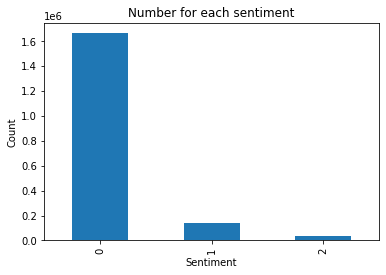

In [ ]:
series1 = new_data['Antivax'].value_counts()
ax = series1.plot(kind='bar', title='Number for each sentiment')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
plt.show()

In [ ]:
series1

0    1664558
1     143286
2      33632
Name: Antivax, dtype: int64

Agregação por data e classificação

In [ ]:
table = new_data.groupby([new_data['date'], 'Antivax'], as_index=False).agg(total=pandas.NamedAgg(column= 'Antivax', aggfunc='count'))
table

,date,Antivax,total
0,2021-01-29,0,15167
1,2021-01-29,1,964
2,2021-01-29,2,371
3,2021-01-30,0,11940
4,2021-01-30,1,825
...,...,...,...
97,2021-06-29,1,3900
98,2021-06-29,2,959
99,2021-06-30,0,82840
100,2021-06-30,1,6401


In [ ]:
class_by_date = table.pivot(index = 'date', columns = 'Antivax', values = 'total')
class_by_date

Antivax,0,1,2
date,,,
2021-01-29,15167,964,371
2021-01-30,11940,825,294
2021-01-31,9366,536,177
2021-05-31,4242,372,182
2021-06-01,32645,2663,726
2021-06-02,34570,2818,690
2021-06-03,26041,2397,466
2021-06-04,34294,3292,612
2021-06-05,28532,3055,542


In [ ]:
class_by_date.rename(columns = {0: 'favor', 1: 'neutro', 2: 'anti'}, inplace=True)

Text(0.5, 1.0, 'Evolução por data')

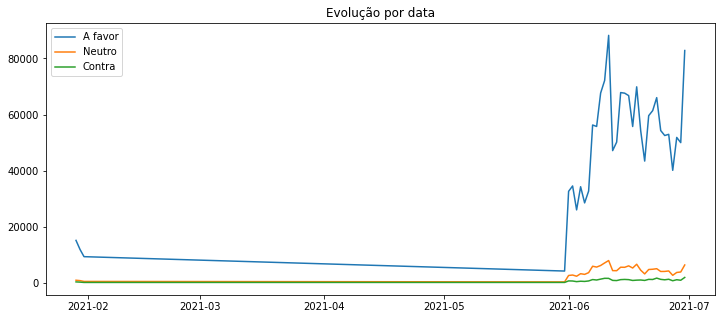

In [ ]:
plt.figure(figsize=(12,5))
#class_by_date.plot()
plt.plot(class_by_date)
plt.legend(["A favor", "Neutro", "Contra"])
plt.title('Evolução por data')